
# Setup


## Imports


In [1]:
%load_ext autoreload

In [3]:
%autoreload 2

from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras import losses

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    VolumeCropSequence, MetaCrop3DGenerator, ET3DUniformCuboidAlmostEverywhere, 
    UniformGridPosition, GTUniformEverywhere, ET3DConstantEverywhere, 
    VSConstantEverywhere, GTConstantEverywhere, SequentialGridPosition
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg import callbacks as tomo2seg_callbacks

In [5]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-4-cf972d05bc84>:<module>:004}::[2020-11-21::19:09:56.673]
runid=1605982196



In [6]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
# strategy = tf.distribute.MirroredStrategy(devices=[""])  


DEBUG::tomo2seg::{<ipython-input-6-7a7728cf1275>:<module>:001}::[2020-11-21::19:09:58.717]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-6-7a7728cf1275>:<module>:002}::[2020-11-21::19:09:58.734]
Num GPUs Available: 0
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-6-7a7728cf1275>:<module>:003}::[2020-11-21::19:09:58.837]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[]
tf.config.list_logical_devices('GPU')=[]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


# Data

In [7]:
from tomo2seg.datasets import (
#     VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

INFO::tomo2seg::{<ipython-input-7-cdb1781c8ebd>:<module>:010}::[2020-11-21::19:09:59.129]
volume_name='PA66GF30' volume_version='v1-reduced' labels_version='refined3'



In [8]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)
logger.debug(f"{voldata_train.shape=} {voldata_val.shape=}")

del voldata

## Labels
vollabels = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{vollabels.shape=}")

vollabels_train = volume.train_partition.get_volume_partition(vollabels)
vollabels_val = volume.val_partition.get_volume_partition(vollabels)
logger.debug(f"{vollabels_train.shape=} {vollabels_val.shape=}")

del vollabels

DEBUG::tomo2seg::{data.py:with_check:220}::[2020-11-21::19:09:59.368]
vol=Volume(name='PA66GF30', version='v1-reduced', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:238}::[2020-11-21::19:09:59.378]
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.labels.raw

Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.weights.raw

DEBUG::tomo2seg::{data.py:metadata:177}::[2020-11-21::19:09:59.380]
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.metadata.yml`.

INFO::tomo2seg::{<ipython-input-8-3d9af8b98d34>:<module>:007}::[2020-11-21::19:09:59.393]
volume=Volume(name='PA66GF30', version='v1-reduced', _metadata=Volume.Metadata(dimensions=[256, 256, 256], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 256], 'y_range': [0, 256], 'z_range': [0, 128], 'alias'

# Data crop sequences

In [9]:
batch_size_per_replica = 16  
batch_size = batch_size_per_replica * (n_replicas := strategy.num_replicas_in_sync)

logger.info(f"{batch_size_per_replica=}\n{n_replicas=}\n{batch_size=}")

common_random_state = 143
crop_shape = (256, 256, 1)  # multiple of 16 (requirement of a 4-level u-net)

INFO::tomo2seg::{<ipython-input-9-78b1c7abfa0e>:<module>:004}::[2020-11-21::19:09:59.857]
batch_size_per_replica=16
n_replicas=1
batch_size=16



## Train

In [41]:
data = voldata_train
labels = vollabels_train
volume_shape = data.shape
labels_list = volume.metadata.labels

crop_seq_train = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    labels=labels_list,
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape,
        crop_shape=crop_shape,
        x0y0z0_generator=(
            grid_pos_gen := UniformGridPosition.build_from_volume_crop_shapes(
                volume_shape=volume_shape, 
                crop_shape=crop_shape,
                random_state=RandomState(common_random_state),
            )
        ),
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator_=grid_pos_gen),
        gt_field=GTUniformEverywhere.build_2d(
            random_state=RandomState(common_random_state),
            grid_position_generator_=grid_pos_gen,
        ),
        vs_field=VSConstantEverywhere.build_no_shift(grid_position_generator_=grid_pos_gen),
    ),
    batch_size=batch_size,
    # this volume cropper only returns random crops, 
    #so the number of crops per epoch/batch is w/e i want
    epoch_size=100,
    meta_crops_hist_path=None,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
)

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:145}::[2020-11-21::19:26:55.985]
Built UniformGridPosition from volume_shape=(256, 256, 128) and crop_shape=(256, 256, 1) ==> {'x_range': (0, 1), 'y_range': (0, 1), 'z_range': (0, 128)}

INFO::tomo2seg::{volume_sequence.py:_build:227}::[2020-11-21::19:26:55.988]
Building ET3DConstantEverywhere with {x, y, z}_range from grid_position_generator=UniformGridPosition(x_range=(0, 1), y_range=(0, 1), z_range=(0, 128), random_state=RandomState(MT19937) at 0x7F6FB3BB3340)

INFO::tomo2seg::{volume_sequence.py:_build:227}::[2020-11-21::19:26:55.989]
Building GTUniformEverywhere with {x, y, z}_range from grid_position_generator=UniformGridPosition(x_range=(0, 1), y_range=(0, 1), z_range=(0, 128), random_state=RandomState(MT19937) at 0x7F6FB3BB3340)

INFO::tomo2seg::{volume_sequence.py:_build:227}::[2020-11-21::19:26:55.990]
Building VSConstantEverywhere with {x, y, z}_range from grid_position_generator=UniformGridPosition(x_range=(0

## Val

In [11]:
# val volume

data = voldata_val
labels = vollabels_val
volume_shape = data.shape
labels_list = volume.metadata.labels

crop_seq_val = VolumeCropSequence(
    # data source
    data_volume=data,
    labels_volume=labels,
    labels=labels_list,
    
    # data augmentation
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape,
        crop_shape=crop_shape,
        x0y0z0_generator=(
            grid_pos_gen := SequentialGridPosition.build_min_overlap(
                volume_shape=volume_shape, crop_shape=crop_shape,
            )
        ),
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator_=grid_pos_gen),
        gt_field=GTConstantEverywhere.build_gt2d_identity(grid_position_generator_=grid_pos_gen),
        vs_field=VSConstantEverywhere.build_no_shift(grid_position_generator_=grid_pos_gen),
    ),
    
    # others
    batch_size=batch_size,
    epoch_size=len(grid_pos_gen),  # go through all the crops in validation    
    meta_crops_hist_path=None,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
)

INFO::tomo2seg::{volume_sequence.py:build_min_overlap:202}::[2020-11-21::19:10:00.518]
Building SequentialGridPosition with minimal overlap (smallest n_steps in each directions) n_steps={'n_steps_x': 1, 'n_steps_y': 1, 'n_steps_z': 64}.

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:145}::[2020-11-21::19:10:00.520]
Built SequentialGridPosition from volume_shape=(256, 256, 64) and crop_shape=(256, 256, 1) ==> {'x_range': (0, 1), 'y_range': (0, 1), 'z_range': (0, 64)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:184}::[2020-11-21::19:10:00.522]
The SequentialGridPosition has len(self.positions)=64 different positions (therefore crops).

INFO::tomo2seg::{volume_sequence.py:_build:227}::[2020-11-21::19:10:00.523]
Building ET3DConstantEverywhere with {x, y, z}_range from grid_position_generator=SequentialGridPosition(x_range=(0, 1), y_range=(0, 1), z_range=(0, 64), n_steps_x=1, n_steps_y=1, n_steps_z=64)

INFO::tomo2seg::{volume_sequence.py:_build:227}::[2020-11-21

# Model

In [12]:
try:
    tomo2seg_model
except NameError:
    print("already deleted (:")
else:
    del tomo2seg_model

already deleted (:


In [13]:
from cnn_segm import keras_custom_loss

In [14]:
model_master_name = "unet-2d-small"
model_version = "vanilla00"

In [15]:
model_factory_function = modular_unet.u_net
model_factory_kwargs = dict(
    input_shape = crop_shape,
    nb_filters_0 = 1,
)

try:
    tomo2seg_model
    
except NameError:
    
    tomo2seg_model = Tomo2SegModel(
        model_master_name, 
        model_version, 
        runid=runid,
        factory_function=model_factory_function,
        factory_kwargs=model_factory_kwargs,
    )
                
else:
    logger.warning("The model is already defined. To create a new one: `del tomo2seg_model`")

finally:
    
    logger.info(f"{tomo2seg_model=}")
    
    logger.info("Compiling model.")
    
    with strategy.scope():
        if not tomo2seg_model.autosaved_model_path.exists():
#             assert not tomo2seg_model.model_path.exists(), f"Please delete '{tomo2seg_model.model_path}' to resave it if you wish to regenerate it."
            model = model_factory_function(
                output_channels=len(volume.metadata.labels), 
                name=tomo2seg_model.name,
                **model_factory_kwargs
            )
        else:
            logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
            model = keras.models.load_model(tomo2seg_model.autosaved_model_path_str)
       
        model.compile(
            loss=keras_custom_loss.jaccard2_loss, 
            optimizer=optimizers.Adam(lr=.003)
        )
        model.save(tomo2seg_model.model_path)

INFO::tomo2seg::{<ipython-input-15-53f1c9b91b55>:<module>:025}::[2020-11-21::19:10:02.768]
tomo2seg_model=Model(master_name='unet-2d-small', version='vanilla00', fold=0, runid=1605982196, factory_function='tomo2seg.modular_unet.u_net', factory_kwargs={'input_shape': (256, 256, 1), 'nb_filters_0': 1})

INFO::tomo2seg::{<ipython-input-15-53f1c9b91b55>:<module>:027}::[2020-11-21::19:10:02.770]
Compiling model.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/joaopcbertoldo/projects/tomo2seg/data/models/unet-2d-small.vanilla00.000.1605-982-196/assets


In [16]:
# write the model summary in a file
with tomo2seg_model.summary_path.open("w") as f:
    def print_to_txt(line):
        f.writelines([line + "\n"])
    model.summary(print_fn=print_to_txt, line_length=140)
    
# same for the architecture
utils.plot_model(model, show_shapes=True, to_file=tomo2seg_model.architecture_plot_path);

logger.info(f"Check the summary and the figure of the model in the following locations:\n{tomo2seg_model.summary_path}\n{tomo2seg_model.architecture_plot_path}")

INFO::tomo2seg::{<ipython-input-16-1a966c379837>:<module>:010}::[2020-11-21::19:10:18.252]
Check the summary and the figure of the model in the following locations:
/home/joaopcbertoldo/projects/tomo2seg/data/models/unet-2d-small.vanilla00.000.1605-982-196/summary.txt
/home/joaopcbertoldo/projects/tomo2seg/data/models/unet-2d-small.vanilla00.000.1605-982-196/architecture.png



# Callbacks

In [17]:
autosave_cb = keras_callbacks.ModelCheckpoint(
    tomo2seg_model.autosaved_model_path_str, 
    monitor="val_loss", 
    verbose=0, 
    save_best_only=True, 
    mode="auto",
)

history_cb = tomo2seg_callbacks.History(
    optimizer=model.optimizer,
    backup=5,
    csv_path=tomo2seg_model.history_path,
)

# Summary before training

stuff that i use after the training but i want it to appear in the 


## Metadata

todo put this back to work

## Volume slices

todo put this back to work

## Generator samples

todo put this back to work

# Learning rate range test

todo put this back to work


# Training


In [18]:
# model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

In [19]:
from tensorflow.keras import backend as K

lr = 0.001
K.set_value(model.optimizer.learning_rate, lr)

callbacks = [
    autosave_cb,
    history_cb,
    keras_callbacks.TerminateOnNaN(),
]

In [102]:
n_epochs = 100

model.fit(
    # data sequences
    x=crop_seq_train,
    validation_data=crop_seq_val,
    
    # epochs
    initial_epoch=history_cb.last_epoch + 1,  # for some reason it is 0-starting and others 1-starting...
    epochs=history_cb.last_epoch + 1 + n_epochs,  
    
    # others
    callbacks=callbacks,  
    verbose=2,
    use_multiprocessing=False,   
);

Epoch 104/203


KeyboardInterrupt: 

INFO::tomo2seg::{viz.py:mark_min_values:284}::[2020-11-22::14:34:31.415]
train: argmin=94 --> min=0.0414

INFO::tomo2seg::{viz.py:mark_min_values:284}::[2020-11-22::14:34:31.422]
val: argmin=89 --> min=0.0345



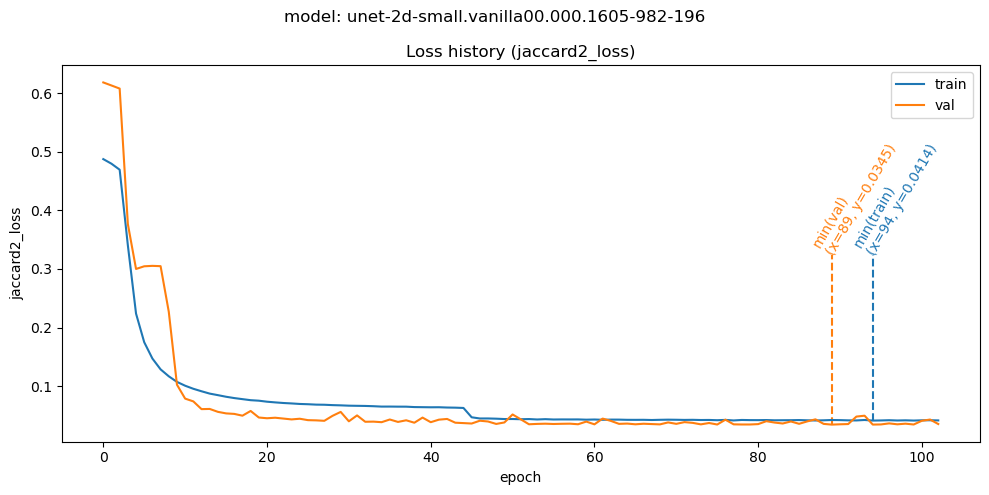

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
fig.set_tight_layout(True)

hist_display = viz.TrainingHistoryDisplay(
    history_cb.history, 
    model_name=tomo2seg_model.name,
    loss_name=model.loss.__name__,
).plot(axs, with_lr=False)

viz.mark_min_values(hist_display.ax_loss_, hist_display.plots_["loss"][0])
viz.mark_min_values(hist_display.ax_loss_, hist_display.plots_["val_loss"][0])

hist_display.fig_.savefig(
    tomo2seg_model.model_path / (hist_display.title + ".png"),
    format='png',
)

In [87]:
history_cb.dataframe.to_csv(history_cb.csv_path, index=True)

In [81]:
model.save(tomo2seg_model.model_path)

INFO:tensorflow:Assets written to: /home/joaopcbertoldo/projects/tomo2seg/data/models/unet-2d-small.vanilla00.000.1605-982-196/assets
